# Addition is All You Need: Tutorial

The idea of the paper is to introduce a new multiplication operator (namely $\mathcal{L}$-mul) which is more efficient in computational terms with respect to a canonical multiplication. To achieve this an approximation is introduced, so the result will not be exact, yet good enough for being used as part of the attention mechanism of LLMs.

The prodosed operator is designed to be implemented at hardware level, and there are chances that future dedicated hardware will adopt it for the design of their "AI-cores".

In the following tutorial, we are going to:
- lay out the theory behind the proposed method;
- implement a simple kernel for $\mathcal{L}$-mul;
- evaluate the computational accuracy  

# Float numbers

Float numbers are defined by the technical standard IEEE-754 (1985).

Under this representation each number (under binary format) is composed by the 3 parts: **sign**, **exponent** and **mantissa** (also known as fraction)

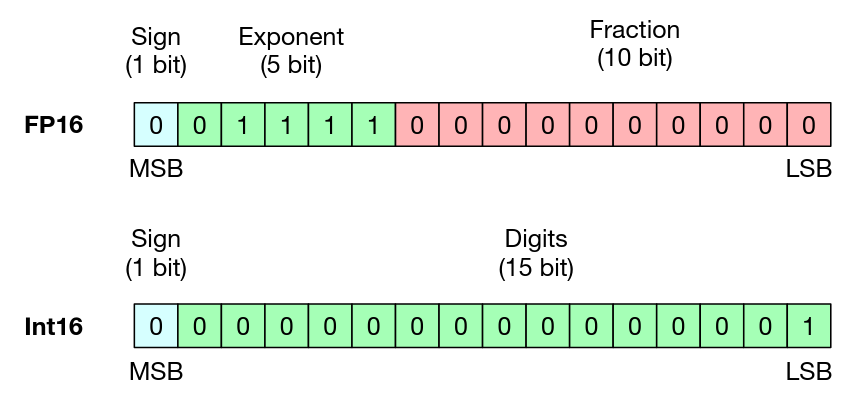

Decimal value of a number is then: $(-1)^{s} \cdot F \cdot 2^{E}$

Where $F = (1 + m)$, which is the **normalized** version of $m$. This is a convention of IEEE-754, each normalized fraction (in 24-bit definition) has the most-left bit at 1, since it is always at 1 there is no need to store, **but** we need to add it at every operation accordingly. $2^0 = 1$.

Instead, $E = e - (2^{k-1}-1)$. The exponent is **biased** to account for the fact that the values that can be represented are split between positive and negative in equal parts. $2^{k-1} -1$ is half of the values that can be represented.

If we have to compute a float number by hand this would be the procedure.

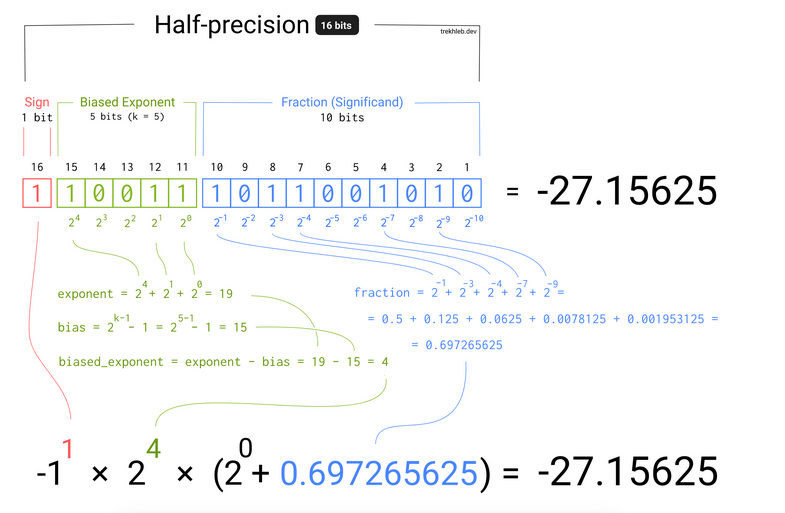

In [6]:
import struct

def float_to_ieee754(num, precision='single'):
    abbr = {"single": ['!f', '!L'], "double": ['!d', '!Q']}
    packed = struct.pack(abbr[precision][0], num)
    integer = struct.unpack(abbr[precision][1], packed)[0]
    
    book = {"single": [31, 23, 0xFF, 0x7FFFFF], "double": [63, 52, 0x7FF, 0xFFFFFFFFFFFFF]}
    v = book[precision]

    sign = (integer >> v[0]) & 0x01
    exponent = (integer >> v[1]) & v[2] 
    fraction = integer & v[3]  
    
    fill = {"single": [8, 23], "double": [11, 52]}
    return (    
        f"Sign: {sign}",
        f"Exponent (raw): {bin(exponent)[2:].zfill(fill[precision][0])}",
        f"Exponent: {exponent}",
        f"Fraction (raw): {bin(fraction)[2:].zfill(fill[precision][1])}",
    )

# Example usage
sign, exp_r, exp, frac_r = float_to_ieee754(11.0, precision='single')
print(f"{sign}\n{exp_r}\n{exp}\n{frac_r}\n")
sign, exp_r, exp, frac_r = float_to_ieee754(2.0, precision='single')
print(f"{sign}\n{exp_r}\n{exp}\n{frac_r}\n")


Sign: 0
Exponent (raw): 10000010
Exponent: 130
Fraction (raw): 01100000000000000000000

Sign: 0
Exponent (raw): 10000000
Exponent: 128
Fraction (raw): 00000000000000000000000



In [7]:
# custom class of IEEE 754 float 
class number:
    def __init__(self, num):
        self.num = num
        self.pack()
        self.unpack()
        self.format()
    
    def pack(self):
        self.packed = struct.pack(self.abbr, self.num)
        return self.packed
        
    def unpack(self):
        self.unpacked = struct.unpack(self.form, self.pack())[0]
        return self.unpacked
    
# function for normal FP multiplication
class Float(number):
    def __init__(self, num):
        super().__init__(num)
    
    # according to IEEE 754 standard
    def format(self):
        self.sign = (self.unpacked >> self.sign_idx) & 0x01
        self.exp = (self.unpacked >> self.exp_idx) & self.exp_size_hex 
        self.exp_bin = bin(self.exp)[2:].zfill(self.exp_length)
        
        self.fraction = self.unpacked & self.fraction_size_hex 
        self.fraction_bin = bin(self.fraction)[2:].zfill(self.fraction_length) 
        
        self.exp_bias = 2 ** (self.exp_length - 1) - 1
        self.IEEE754_dec = (-1) ** self.sign * 2 ** (self.exp - self.exp_bias) * (1 + sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(self.fraction_bin))) 
    
    def print(self):
        print(f"Num (dec): {self.num}\n",  
            f"Sign: {self.sign}\n",
            f"Exponent (bit): {self.exp_bin}\n",
            f"Exponent: {self.exp}\n",
            f"Fraction (bit): {self.fraction_bin}\n",
            f"decimal: {self.IEEE754_dec}\n",)
    
class Float32(Float):
    def __init__(self, num):
        self.abbr = '!f'
        self.form = '!L'
        self.bits = 32
        self.sign_idx = 31
        self.exp_idx = 23
        self.exp_size_hex = 0xFF
        self.fraction_size_hex = 0x7FFFFF
        self.exp_length = 8
        self.fraction_length = 23
        
        super().__init__(num)

## Float Multiplications

The standard also defines how different operation between float numbers are computed. In our case we are interested to check out the multiplication operator. Given two float numbers $a$ and $b$, $c = a \cdot b$ in decimal form is equal to:

$$c = (-1 ^ {a_s \oplus b_s}) \cdot (1 + a_m) \cdot (1 + b_m) \cdot 2^{a_E + b_E} = (1 + a_m + b_m + a_m \cdot b_m) \cdot 2^{a_E + b_E}$$

each part of $c$ is then:

$$c_s = {a_s \oplus b_s} \\
c_m = (1 + a_m) \cdot (1 + b_m) - 1 \\
c_e = a_E + b_E + bias = (a_e - bias) + (b_e - bias) + bias = a_e + b_e - bias
$$

The main **bottleneck** (at hardware perspective) of this operation is mantissa multiplication.


In [8]:
import struct

def FPmul(A, B, precision='single'):
    if precision=='single': 
        x = Float32(A)
        y = Float32(B)
    else:
        NotImplementedError("Only single precision is implemented")
    x_s = x.sign
    y_s = y.sign
    x_e = (x.exp - x.exp_bias)
    y_e = (y.exp - y.exp_bias)
    x_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(x.fraction)[2:].zfill(x.fraction_length)))
    y_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(y.fraction)[2:].zfill(y.fraction_length)))
    return (-1) ** (x_s ^ y_s) * (1 + x_m + y_m + x_m * y_m) * 2**(x_e + y_e)

print(FPmul(5,5))   

25.0


## $\mathcal{L}$-mul

The paper propose to swap the mantissa multiplication $x_m * y_m$ with an offset operator $2^{-l(m)}$ where $l(m) =
\begin{cases}
m & \text{if } m \leq 3, \\
3 & \text{if } m = 4, \\
4 & \text{if } m > 4.
\end{cases}$

These values derive from empirical observation on the results achieved on LLM testing, while using the $\mathcal{L}$-mul. Ultimately resulting in:

$$c = (-1 ^ {a_s \oplus b_s}) \cdot (1 + a_m + b_m + 2^{-l(m)}) \cdot 2^{a_E + b_E} \quad \textrm{with} \quad l(m) =
\begin{cases}
m & \text{if } m \leq 3, \\
3 & \text{if } m = 4, \\
4 & \text{if } m > 4.
\end{cases}$$

By doing so we reduce a multiplication to a simple concatenation of additions. Follows the computation equivalent.

In [ ]:

def l_operator(x):
    offset = lambda x: 2 ** (-x)
    if x.fraction_length <= 3:
        x_l = offset(x.fraction_length)
    elif x.fraction_length == 4:
        x_l = offset(x.fraction_length)
    else:
        x_l = offset(4) 
    return x_l

def Lmul(A, B, precision='single'):
    if precision=='single': 
        x = Float32(A)
        y = Float32(B)
    else:
        NotImplementedError("Only single precision is implemented")
    x_s = x.sign
    y_s = y.sign
    x_e = (x.exp - x.exp_bias)
    y_e = (y.exp - y.exp_bias)
    
    l = l_operator(x)
    
    x_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(x.fraction)[2:].zfill(x.fraction_length)))
    y_m = sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(bin(y.fraction)[2:].zfill(y.fraction_length)))
    return (-1) ** (x_s ^ y_s) * (1 + x_m + y_m + l) * 2**(x_e + y_e)


25.0
25.0


This is an approximation so some error with respect to the original Floating Points multiplication is introduced.

In [109]:
print(FPmul(5,5))   
print(Lmul(5,5))

print(FPmul(3,4))   
print(Lmul(3,4))

25.0
25.0
12.0
12.5


We plot below the error distribution over $a \cdot b$ given $a, b = [-5 ... 5]$

Text(0.5, 1.0, 'FPmul - Lmul(sotfware)')

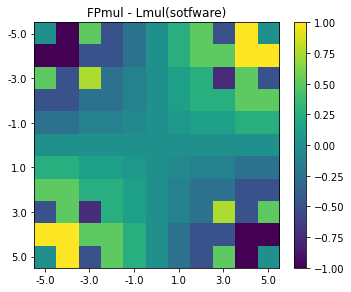

In [114]:
import matplotlib.pyplot as plt
import numpy as np

N = 11
precision = 'single'
num_abs_range = 5
x_range = np.linspace(-num_abs_range, num_abs_range, N)
y_range = np.linspace(-num_abs_range, num_abs_range, N)

X, Y = np.meshgrid(x_range, y_range)
z = np.zeros(X.shape)
k = np.zeros(X.shape)

for i, x_row in enumerate(X):
    for j, x in enumerate(x_row):
            y = Y[i, j]
            gt = FPmul(x, y, precision=precision) 
            z[i, j] = gt - Lmul(x, y, precision=precision)

fig, axs = plt.subplots(1)

x_labels = [f"{x:.1f}" for i, x in enumerate(x_range) if i % (N // 5)==0]
y_labels = [f"{y:.1f}" for i, y in enumerate(y_range) if i % (N // 5)==0]

im= axs.imshow(z, cmap='viridis')
fig.colorbar(im, ax=axs, fraction=0.046, pad=0.04)

fig.tight_layout()

tick_positions = [idx for idx, _ in enumerate(x_range) if idx % (N // 5) == 0]
axs.set_xticks(tick_positions)
axs.set_xticklabels(x_labels)
axs.set_yticks(tick_positions)
axs.set_yticklabels(y_labels)

axs.set_title('FPmul - Lmul(sotfware)')


At hardware implementation level the $\mathcal{L}$-mul operator boils down to:

1 - bitcasting float type as int \
2 - adding int digits and subtracting the offset \
3 - bitcasting int type as float

Given the previous expression of the $\mathcal{L}$-mul  

$$c = (-1 ^ {a_s \oplus b_s}) \cdot (1 + a_m + b_m + 2^{-l(m)}) \cdot 2^{a_E + b_E} \quad \textrm{with} \quad l(m) =
\begin{cases}
m & \text{if } m \leq 3, \\
3 & \text{if } m = 4, \\
4 & \text{if } m > 4.
\end{cases}$$

in the mantissa computation we can assume that the $1 + ...$ part is intrisincally taken care from the normalization process inherit of the IEEE754 standard.

By bitcasting to int and summing the addition takes care of the sum of the of exponent part that needs to be complemented by subtraction of the bias term. If we consider a 32bit operation, hence a 8-bit float exponent, the bias term is going to be $2^{8-1}-1$ = 127. We need to account for the mantissa bits, so we bit shift by 22, giving us 0x7F000000.

Let's consider now the mantissa part of the operation. $a_m$ and $b_m$ are added to the offset $l(m)$. 
In this case $l(m)=4$, giving a positive offset of $2^{-4}$, which in float representation equals to 0x100000. 

**Overall the offset would be equal 0x7F000000 - 0x100000 = 0x3F780000**

Normally in a FP multiplication there is the need to have a carry operation to account in case the mantissa is over 1. This is accounted automaticcally since we are adding digits.

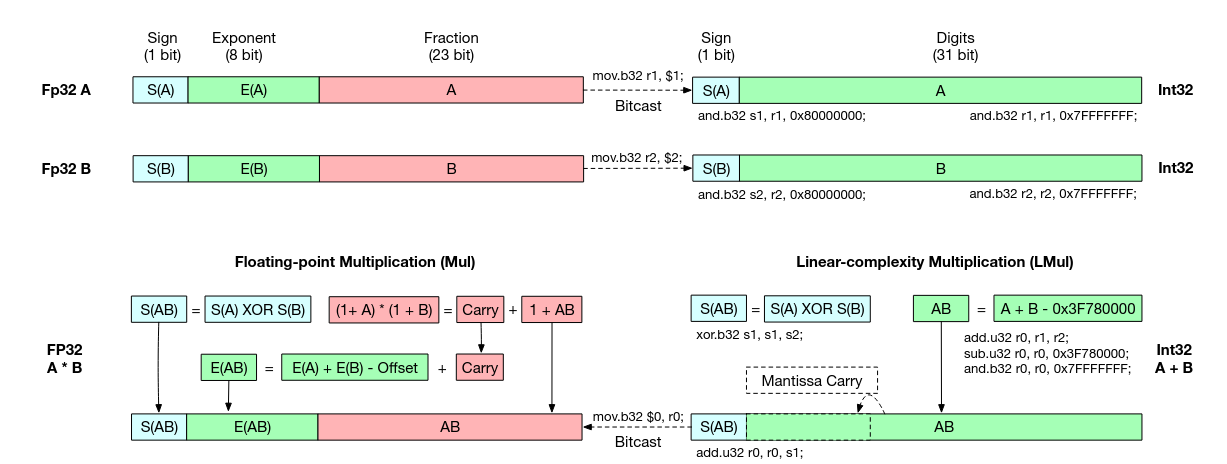

Let's instantiate a custom integer class

In [96]:
import struct 
    
class Int(number):
    def __init__(self, num):
        num = int(num)
        super().__init__(num)

    def format(self):
        self.sign = (self.unpacked >> self.sign_idx) & 0x01
        self.digit = (self.unpacked) & self.digit_size_hex
        self.digit_bin = bin(self.digit)[2:].zfill(self.digit_length)
        
        self.dec = (-1) ** self.sign * int(self.digit_bin, 2)
    
    def print(self):
        print(f"Num (dec): {self.num}\n",  
            f"Sign: {self.sign}\n",
            f"Digits (bit): {self.digit_bin}\n",
            f"decimal: {self.dec}\n",)
        
class Int32(Int):
    def __init__(self, num):
        self.abbr = '!i'
        self.form = '!L'
        self.bits = 32
        self.sign_idx = 31
        self.digit_idx = 0
        self.digit_size_hex = 0x7FFFFFFF
        self.digit_length = 31
        
        super().__init__(num)

Let's now implement what we saw for the hardware implementation above

In [122]:
# bitcasst functions
def Float2Int(fnum):
    """Bitcast float to int"""
    temp = Int32(fnum.num) # create a placeholder for the int
    temp.sign = fnum.sign # swap sign
    temp.digit_bin = fnum.exp_bin + fnum.fraction_bin # swap digits
    temp.digit = int(temp.digit_bin.zfill(temp.digit_length), 2) 
    temp.dec = (-1) ** temp.sign * int(temp.digit_bin, 2) 
    return temp

def Int2Float(inum):
    """Bitcast float to int"""
    temp = Float32(inum.num) # create a placeholder for the int
    temp.sign = inum.sign # swap sign
    temp.exp = (inum.digit >> temp.exp_idx) & temp.exp_size_hex 
    temp.exp_bin = bin(temp.exp)[2:].zfill(temp.exp_length)
    
    temp.fraction = inum.digit & temp.fraction_size_hex 
    temp.fraction_bin = bin(temp.fraction)[2:].zfill(temp.fraction_length)
    
    temp.IEEE754_dec = (-1) ** temp.sign * 2 ** (temp.exp - temp.exp_bias) * (1 + sum(int(bit) * 2 ** -(i + 1) for i, bit in enumerate(temp.fraction_bin)))     
    return temp


In [126]:
a = Float32(5)
b = Float32(5)

c_int = Int32(0) # placeholder for the result
c_FP = Float32(0) # placeholder for the result

# 1 float to int bitcast
a_int = Float2Int(a)
b_int = Float2Int(b)

# 2 sign xor and int addition 
c_int.sign = (a_int.sign ^ b_int.sign)
c_int.digit = (a_int.digit + b_int.digit - 0x3F780000) & 0x7FFFFFFF # & 0x7FFFFFFF to adjust for overflow , and only consider 32 bits  

# 3 int to float bitcast
c_FP = Int2Float(c_int)

c_FP.print()


Num (dec): 0
 Sign: 0
 Exponent (bit): 10000011
 Exponent: 131
 Fraction (bit): 10010000000000000000000
 decimal: 25.0



Finally, We plot below the error distribution over $a \cdot b$ given $a, b = [-5 ... 5]$ considering the hardware implementation, and we compare to the software one.

Text(0.5, 1.0, 'FPmul - Lmul(hardware)')

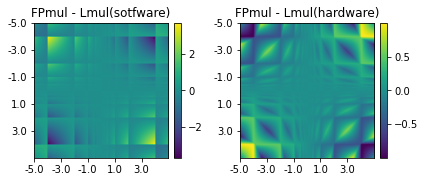

In [144]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

N = 1000
precision = 'single'
num_abs_range = 5
x_range = np.linspace(-num_abs_range, num_abs_range, N)
y_range = np.linspace(-num_abs_range, num_abs_range, N)

X, Y = np.meshgrid(x_range, y_range)
z = np.zeros(X.shape)
k = np.zeros(X.shape)

c_int = Int32(0) # placeholder for the result
c_FP = Float32(0) 

for i, x_row in enumerate(X):
    for j, x in enumerate(x_row):
            y = Y[i, j]
            gt = FPmul(x, y, precision=precision) 
            z[i, j] = gt - Lmul(x, y, precision=precision)
            
            # 1 float to int bitcast
            x_int = Float2Int(Float32(x))
            y_int = Float2Int(Float32(y))

            # 2 sign xor and int addition 
            c_int.sign = (x_int.sign ^ y_int.sign)
            c_int.digit = (x_int.digit + y_int.digit - 0x3F780000) & 0x7FFFFFFF # & 0x7FFFFFFF to adjust for overflow , and only consider 32 bits  

            # 3 int to float bitcast
            c_FP = Int2Float(c_int)

            k[i, j] = gt - c_FP.IEEE754_dec


fig, axs = plt.subplots(1,2)

id2plot = {1:z, 2:k}

x_labels = [f"{x:.1f}" for i, x in enumerate(x_range) if i % (N // 5)==0]
y_labels = [f"{y:.1f}" for i, y in enumerate(y_range) if i % (N // 5)==0]

im= axs[0].imshow(z, cmap='viridis')
fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)
im= axs[1].imshow(k, cmap='viridis')
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

fig.tight_layout()

for i, ax in enumerate(axs):
    tick_positions = [idx for idx, _ in enumerate(x_range) if idx % (N // 5) == 0]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(y_labels)

axs[0].set_title('FPmul - Lmul(sotfware)')
axs[1].set_title('FPmul - Lmul(hardware)')


Trends are similar but not exactly the same, this may have to with the approximation introduced by the rounding